In [81]:
'''
This contains code for generating "Evaluation of FACETs explanation analytics with diverse query workloads"

Experiment results files needed: VaryRobustness, VaryNConstraints, and VaryK

Results used in the paper are provided in "../results/final" if generating new results run each experiment and update the results paths below
'''
# path to each result file
robust_path = "../results/vary_robustness_fig10.csv" # run json merge to obtain if new results
constr_path = "../results/vary_nconstraints_fig10.csv"
k_path = "../results/vary_k_fig10.csv"

# path to output the figure
export_figures = True
output_dir = "./reproducibility/"
fig_save_name = "user_workloads_fig10"
fig_type = ".pdf"

In [82]:

import os
import re
import sys
import glob
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import axis
import matplotlib.ticker as ticker
from matplotlib.axis import Axis

In [83]:
def load_json_results(results_dir):
    '''
    Utility to loads all results files in the given directory and merges them to a single pandas dataframe.
    '''
    results_df = None
    for name in glob.glob(results_dir):
        fname: str = os.path.basename(name)
        if "result" in fname:
            parsed_text = fname.split("_")
            with open(name, "r") as f:
                results = json.load(f)    
                results["dataset"] = parsed_text[0]
                results["explainer"] = parsed_text[1]
                results["min_robust"] = float(parsed_text[2][1:])
                results["iteration"] = int(parsed_text[3])
                if results_df is None:
                    results_df = pd.DataFrame([results])
                else:
                    results_df = pd.concat([results_df, pd.DataFrame([results])])
    return results_df

In [84]:
# set to true and update paths to merge if generating new results
do_merge = False
if do_merge:
    results_dir = "../results/vary-robustness/*"
    output_path = "../results/vary_robustness_merged.csv"
    results_df = load_json_results(results_dir)
    results_df.to_csv(output_path, index=False)
    results_df.head()
    robust_path = output_path

In [85]:
# read in robustness data
robust_results = pd.read_csv(robust_path)

# Group by minimum robustness, dataset taking the average across each iteration
robust_results = robust_results.groupby(["dataset", "min_robust"], as_index=False).mean() 
robust_results["explainer"] = "facet"

keep_values = np.array([0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5000000000000004, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.000000000000001, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]) / 100
idx_keep = robust_results["min_robust"].isin(keep_values)
robust_results = robust_results[idx_keep]
robust_results.head()

,dataset,min_robust,n_trees,max_depth,iteration,accuracy,precision,recall,f1,per_valid,avg_dist,avg_length,prep_time,explain_time,sample_time,n_explain,explainer
0,adult,0.001,100.0,NaN,0.0,0.844666,0.70555,0.622676,0.661527,1.0,0.162322,2.50,104.801075,11.008866,0.550443,20.0,facet
1,adult,0.005,100.0,NaN,0.0,0.844666,0.70555,0.622676,0.661527,1.0,0.167685,2.45,104.801075,9.812425,0.490621,20.0,facet
2,adult,0.010,100.0,NaN,0.0,0.844666,0.70555,0.622676,0.661527,1.0,0.183466,2.65,104.801075,8.358842,0.417942,20.0,facet
3,adult,0.015,100.0,NaN,0.0,0.844666,0.70555,0.622676,0.661527,1.0,0.186375,2.70,104.801075,7.718846,0.385942,20.0,facet
4,adult,0.020,100.0,NaN,0.0,0.844666,0.70555,0.622676,0.661527,1.0,0.194676,2.85,104.801075,6.435515,0.321776,20.0,facet


In [86]:
# read in constraints data
constr_results = pd.read_csv(constr_path)
constr_results = constr_results.groupby(["dataset", "nconstr"], as_index=False).mean() 
constr_results["explainer"] = "facet"
# show results after 2
constr_results = constr_results[(constr_results['nconstr'] > 1)]
constr_results.head()

,dataset,nconstr,n_trees,max_depth,iteration,accuracy,precision,recall,f1,per_valid,avg_dist,avg_manhattan,avg_length,prep_time,explain_time,sample_time,n_explain,explainer
1,adult,2,100.0,NaN,0.0,0.844666,0.70555,0.622676,0.661527,1.0,1.151563,2.292766,5.8500,101.654042,2.080770,0.104039,20.0,facet
2,adult,4,100.0,NaN,0.0,0.844666,0.70555,0.622676,0.661527,0.0,NaN,NaN,NaN,101.654042,0.075014,0.003751,20.0,facet
3,adult,6,100.0,NaN,0.0,0.844666,0.70555,0.622676,0.661527,0.8,2.641640,7.991224,11.4375,101.654042,0.094790,0.004739,20.0,facet
4,adult,8,100.0,NaN,0.0,0.844666,0.70555,0.622676,0.661527,0.0,NaN,NaN,NaN,101.654042,0.073299,0.003665,20.0,facet
5,adult,10,100.0,NaN,0.0,0.844666,0.70555,0.622676,0.661527,1.0,1.836324,4.404495,8.3000,101.654042,0.156149,0.007807,20.0,facet


In [87]:
# read in k data
k_results = pd.read_csv(k_path)
k_results = k_results.groupby(["dataset", "facet_k"], as_index=False).mean() 
k_results["explainer"] = "facet"
# idx_drop = ((k_results["facet_k"] % 2) > 0.00001)  # for even values
idx_drop = ((k_results["facet_k"] % 2) < 0.00001)  # for odd values
k_results = k_results[~idx_drop]
k_results.head()

,dataset,facet_k,n_trees,max_depth,iteration,accuracy,precision,recall,f1,per_valid,avg_dist,avg_manhattan,avg_length,prep_time,explain_time,sample_time,n_explain,explainer
0,adult,1,100.0,NaN,0.0,0.844666,0.70555,0.622676,0.661527,1.0,0.152483,0.219665,2.7,93.480101,8.900977,0.445049,20.0,facet
2,adult,3,100.0,NaN,0.0,0.844666,0.70555,0.622676,0.661527,1.0,0.152483,0.219665,2.7,93.480101,15.610725,0.780536,20.0,facet
4,adult,5,100.0,NaN,0.0,0.844666,0.70555,0.622676,0.661527,1.0,0.152483,0.219665,2.7,93.480101,21.706737,1.085337,20.0,facet
6,adult,7,100.0,NaN,0.0,0.844666,0.70555,0.622676,0.661527,1.0,0.152483,0.219665,2.7,93.480101,23.858275,1.192914,20.0,facet
8,adult,9,100.0,NaN,0.0,0.844666,0.70555,0.622676,0.661527,1.0,0.152483,0.219665,2.7,93.480101,25.935852,1.296793,20.0,facet


In [88]:
# create viz
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
cmap = plt.get_cmap("tab10")
colors = cmap.colors
ds_colors = {    
    "adult" : colors[0],
    "cancer" : colors[1],
    "credit" : colors[2],
    "magic" : colors[3],
    "spambase" : colors[4],
    "compas" : colors[0],
    "glass" : colors[1],
    "vertebral" : colors[2],
}
ds_markers = {
    "adult" : "^",
    "cancer" : "o",
    "credit" : "v",
    "magic" : "s",
    "spambase" : "D",
    "compas": "^",
    "glass": "o",
    "vertebral": "v",
}
marker_size = 10
line_width = 4
lhorz = True
loc = "upper center"
marker_sizes = {
    "adult" : marker_size,
    "cancer" : marker_size,
    "credit" : marker_size,
    "magic" : marker_size,
    "spambase" : marker_size,
    "compas": marker_size,
    "glass": marker_size,
    "vertebral": marker_size,
}

In [89]:
plot_fontsize = 20

results_dict = {
    "min_robust": robust_results,
    "nconstr": constr_results,
    "facet_k": k_results,
}

# plot features
ylabels = ["Explanation Time", "L2 Explanation Distance", "Explanation Sparsity", "Explanation Time", "Explanation Time"]
xlabels = ["Minimum Robustness (% Space)", "Minimum Robustness (% Space)", "Minimum Robustness (% Space)", "N Constraints", "k (Explanations Requested)"]
titles = ["Explantion Time vs Min Robust", "L2-Norm vs Min Robust", "Sparsity vs Min Robust", "Explanation Time vs Nc", "Sample Time vs k"]
xfeats = ["min_robust", "min_robust", "min_robust", "nconstr", "facet_k"]
yfeats = ["sample_time", "avg_dist", "avg_length", "sample_time", "sample_time"]

def render_plot_ax(datasets, xfeats, yfeats, xlabels=None, ylabels=None, save_name=None, xrange=None, yrange=None, xlog=False, lloc=None, ylog=False, yticks_multi=None, yrange_multi=None, ytick_format="{:.2f}", titles=None):
    fig = plt.figure(figsize=[32, 4])
    ax = fig.subplots(nrows=1, ncols=5) #nrows=1, ncols=5, sharex="all")
    
    for i in range(len(yfeats)):
        xfeature = xfeats[i]
        yfeature =  yfeats[i]
        for ds in datasets:
            is_ds = results_dict[xfeature]["dataset"] == ds
            matching_rows = is_ds

            xvals = results_dict[xfeature][matching_rows][xfeature]
            if xfeature == "min_robust":
                xvals = [_ * 100 for _ in xvals]

            ax[i].plot(xvals, results_dict[xfeature][matching_rows][yfeature], label=yfeature, marker=ds_markers[ds], lw=line_width, ms=marker_size)
            ax[i].tick_params(axis='both', which='major', labelsize=plot_fontsize)

            if titles is not None:
                ax[i].set_title("({:s}) {:s}".format(chr(ord('a')+i), titles[i]), fontdict={"fontsize": plot_fontsize})
            if ylabels is not None:
                ax[i].set_ylabel(ylabels[i], fontdict={"fontsize": plot_fontsize})
            if xlabels is not None:
                ax[i].set_xlabel(xlabels[i], fontdict={"fontsize": plot_fontsize})
            ax[i].set_xlim(xrange)
            if yticks_multi is not None:
                ax[i].set_yticks(yticks_multi[i])
                ax[i].set_yticklabels([ytick_format.format(_) for _ in yticks_multi[i]])
            if yrange_multi is not None:
                bottom = yrange_multi[i][0]
                top = yrange_multi[i][1]
                if bottom is not None:
                    ax[i].set_ylim(bottom=bottom)
                if top is not None:
                    ax[i].set_ylim(top=top)
    lines, labels = ax[0].get_legend_handles_labels()
    fig.subplots_adjust(wspace=0.18)


    #fig.subplots_adjust(wspace=0.25)
    legend_labels = [datasets[_].upper() for _ in range(len(datasets))]
    fig.legend(lines, legend_labels, loc="upper center", bbox_to_anchor=(0.51, 1.13), handletextpad=0.5, columnspacing=1, handlelength=1.5, prop={"size": plot_fontsize}, ncol=len(legend_labels))
    if save_name is not None:
        fig.savefig(output_dir + save_name + fig_type, bbox_inches="tight", facecolor='w')


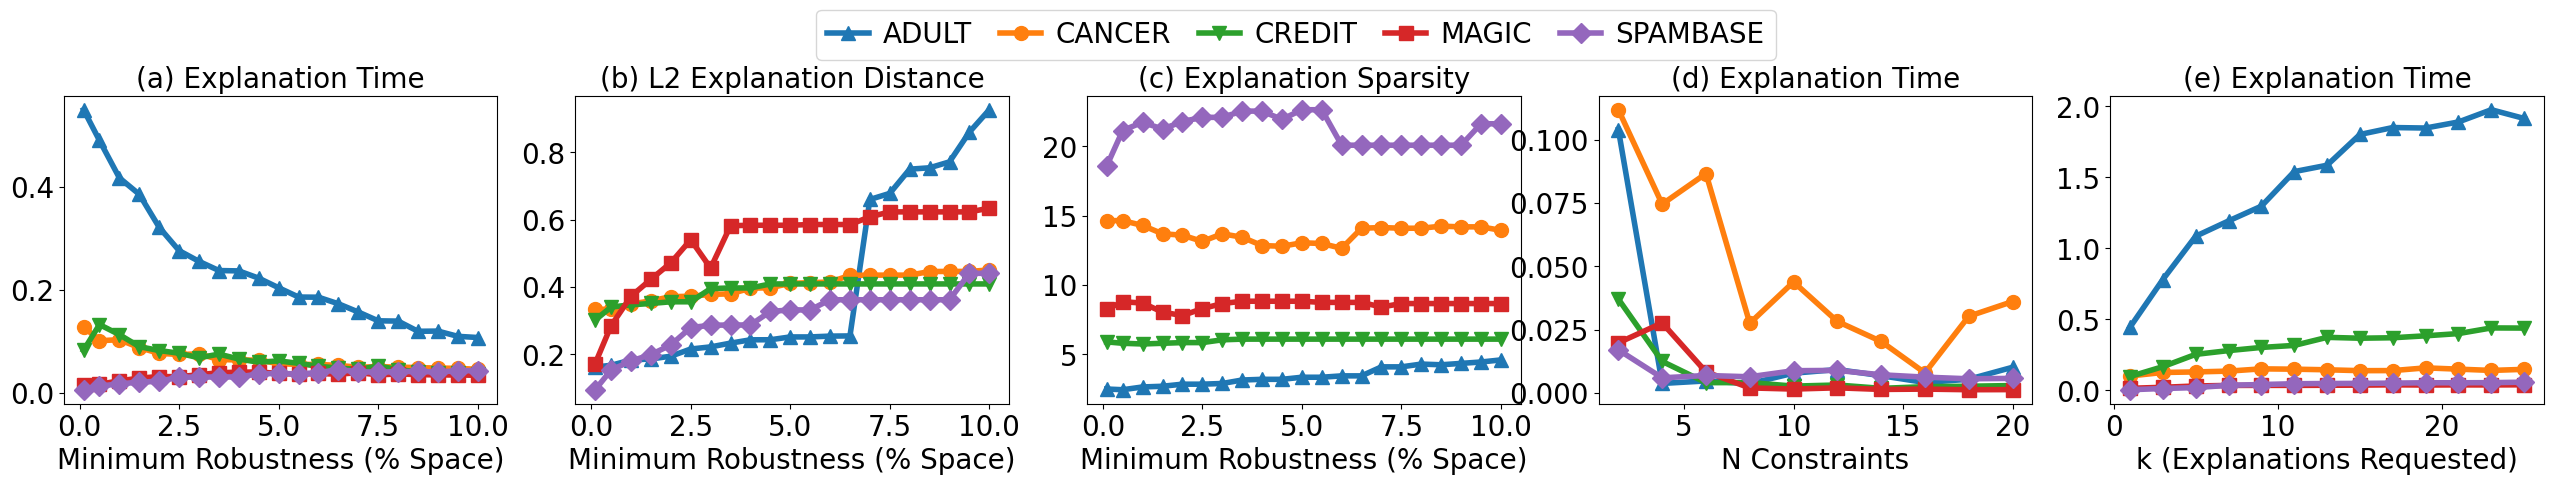

In [90]:
# ########### MAIN PAPER DATASETS
datasets = ["adult", "cancer", "credit", "magic", "spambase"]
# axes bounds
yticks_multi = [[round(_,1) for _ in np.arange(0.0, .45, .1)], [round(_,1) for _ in np.arange(0.0, .45, 0.1)], np.arange(0, 24, 5), [round(_,2) for _ in np.arange(0, .18, 0.05)], np.arange(0.0, 1.54, 0.5)]
yrange_multi = [[-.001, .47], [.13, .49], [1.8, 22], [-.001, .2], [0.0, 1.52]]
# render the plot
render_plot_ax(datasets, xfeats=xfeats, yfeats=yfeats, ylabels=None, xlabels=xlabels, titles=ylabels, save_name=fig_save_name)


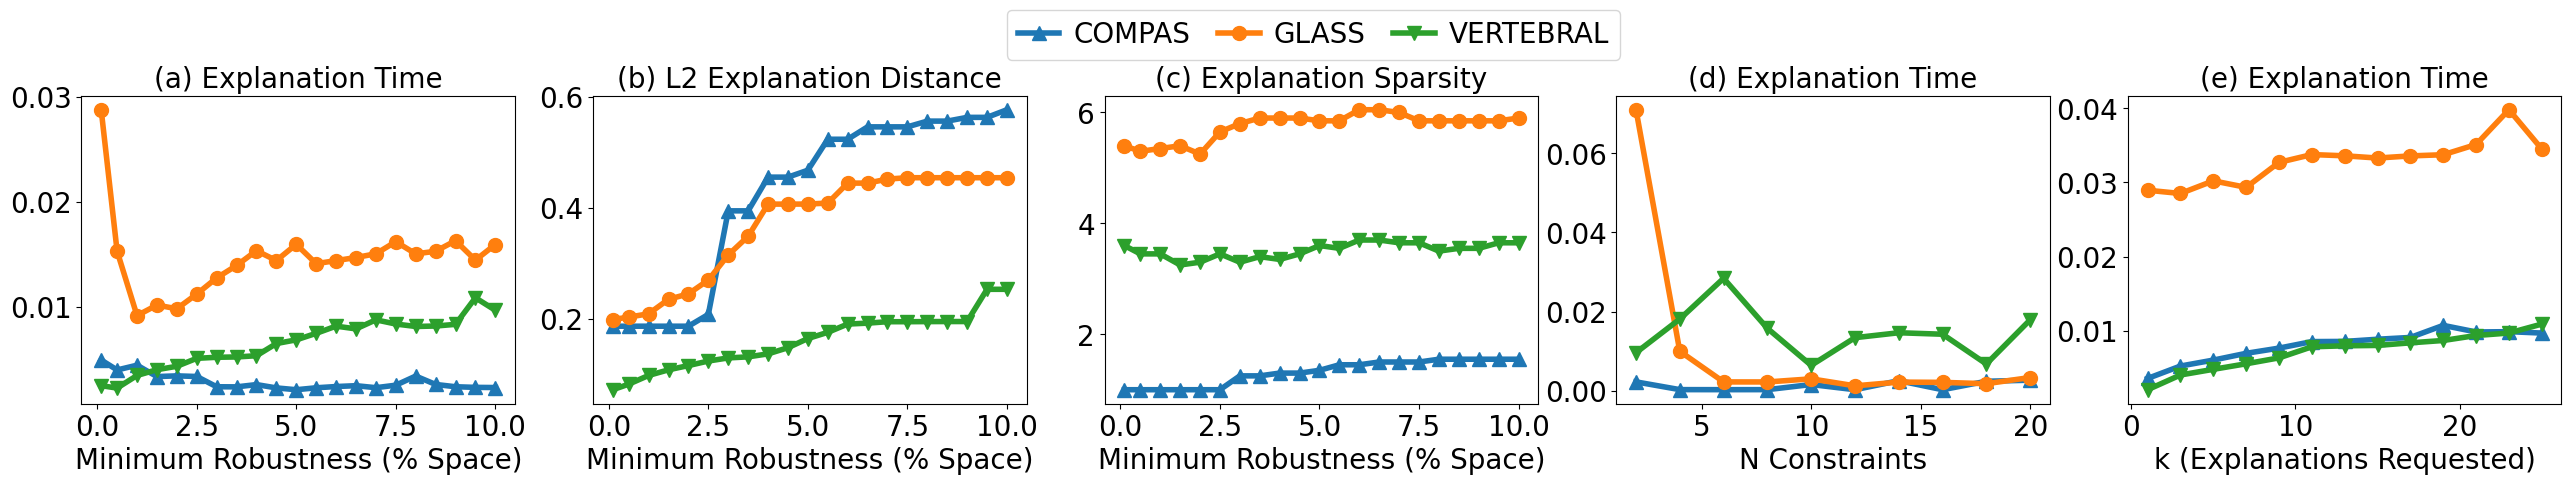

In [91]:
# ########### APPENDIX DATASETS
datasets_apdx = ["compas", "glass", "vertebral"]
# axes bounds
yticks_multi = [np.arange(0.0, .5, .1), [round(_,2) for _ in np.arange(0.0, 1, 0.05)], np.arange(0, 7, 1), np.arange(0, .09, 0.005), np.arange(0.0, .06, 0.01)]
yrange_multi = [[-.001, .5], [0.09, .38], [0.6, 6.6], [0.0, .018], [0.0, .041]]
# render the plot
render_plot_ax(datasets_apdx, xfeats=xfeats, yfeats=yfeats, ylabels=None, xlabels=xlabels, titles=ylabels, save_name=fig_save_name + "_apdx")